## Análise sobre a previsibilidade das decisões de admissibilidade no Superior Tribunal de Justiça usando inteligência artificial

#### *Nota:* Esse notebook é apenas uma cópia dos principais documentos e códigos do projeto.

Os modelos treinados ao final foram treinados em petições reais de processos judiciais.

Sendo assim, esse notebook apenas demonstra os códigos e prova de conceito, mas os dados aos documentos para treinamento dos modelos é considerado dado pessoal nos termos do art. 7.º, §§ 3.º e 4.º da Lei Geral de
Proteção de Dados (Lei n.º 13.709/2018).

Para mais informações e metodologias, consulte a monografia baseada nesse projeto.

In [1]:
#Imports
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from matplotlib.colors import Normalize
from matplotlib import cm
from nltk.corpus import stopwords
from pprint import pprint
from pytz import timezone
from scipy.sparse import load_npz
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, make_scorer, recall_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from tqdm import tqdm
from warnings import filterwarnings
import fitz # Biblioteca do PyMuPDF
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import requests
import seaborn as sns
import spacy
import unicodedata
import xgboost as xgb
tqdm.pandas()  # Inicializa a integração do tqdm com pandas

## Parte 1 - Carregamento dos dados

In [2]:
#Endereço da raiz da base de dados do CNJ.
api_url_root = 'https://dadosabertos.web.stj.jus.br/'
#Lista de pacotes seguindo o esquema da API CKAN.
package_list = 'api/3/action/package_list'
#Exibe a lista de pacotes.
pprint(requests.get(api_url_root + package_list).json())

{'help': 'https://dadosabertos.web.stj.jus.br/api/3/action/help_show?name=package_list',
 'result': ['api-publica-datajud',
            'atas-de-distribuicao',
            'diarias-e-passagens',
            'espelhos-de-acordaos-corte-especial',
            'espelhos-de-acordaos-primeira-secao',
            'espelhos-de-acordaos-primeira-turma',
            'espelhos-de-acordaos-quarta-turma',
            'espelhos-de-acordaos-quinta-turma',
            'espelhos-de-acordaos-segunda-secao',
            'espelhos-de-acordaos-segunda-turma',
            'espelhos-de-acordaos-sexta-turma',
            'espelhos-de-acordaos-terceira-secao',
            'espelhos-de-acordaos-terceira-turma',
            'integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica',
            'movimentacao-processual',
            'plano-estrategico-stj',
            'precedentes-qualificados'],
 'success': True}


O pacote está identificado como `integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica`.

In [3]:
package_id = 'integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica'

In [4]:
#Carrega dados de pacote da API do STJ.
response = requests.get(f'{api_url_root}/api/3/action/package_show?id={package_id}')
#Carrega o arquivo .json
package_info = json.loads(response.text)
#Salva os recursos da query
resources = package_info['result']['resources'] 
#Exibe o primeiro resultado.
resources[0]

{'cache_last_updated': None,
 'cache_url': None,
 'created': '2022-05-19T20:01:02.643048',
 'datastore_active': False,
 'description': 'Dicionário de dados. ',
 'format': 'CSV',
 'hash': '',
 'id': '0488e8aa-33a3-494d-86ef-17889a0155ee',
 'last_modified': '2022-05-19T20:01:02.627455',
 'metadata_modified': '2022-05-19T20:02:05.698389',
 'mimetype': 'text/csv',
 'mimetype_inner': None,
 'name': 'dicionariointegrasdecisoes.csv',
 'package_id': 'a2cd85cc-1391-4ebc-aeed-a45dd75a7987',
 'position': 0,
 'resource_type': None,
 'size': 1536,
 'state': 'active',
 'url': 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/0488e8aa-33a3-494d-86ef-17889a0155ee/download/dicionariointegrasdecisoes.csv',
 'url_type': 'upload'}

Esse resultado é o arquivo .csv que é o dicionário das decisões do STJ nesse dataset.

In [5]:
#Salva o arquivo de dicionário
dicionario = requests.get(resources[0]['url'])
if not os.path.exists('misc'):
    os.makedirs('misc')
if not os.path.exists('misc/dicionariointegrasdecisoes.csv'):
    with open('misc/dicionariointegrasdecisoes.csv', 'w') as file:
        file.write("")
if dicionario.status_code == 200:
        with open(f"./misc/{resources[0]['name']}", 'wb') as f:
            f.write(dicionario.content.decode('iso-8859-1').encode('utf-8')) #É necessário converter a codificação do arquivo.

Salvo o arquivo de dicionário, resta fazer o download dos arquivos de metadados.

Ao momento da conclusão do trabalho, a última atualização no conjunto de dados havia sido em 26 de janeiro de 2024, 18:50 (UTC-03:00).
A última entrada no conjunto de dados na era: metadados20240115.json

Desde então houve entradas posteriores no conjunto de dados.
Para manter resultados similares e considerando as restrições de acesso às petições, a lista de processos analisados será realizada a partir da decisão da entrada em vigor da emenda constitucional n.º 125 de 2022, selecionando os processos com data de decisão no STJ posterior a setembro de 2022, e limitados até a conjunto de metadados de 2024-01-15, listado acima.

Referidos dados estão no arquivo ```lista_documentos.json```

In [6]:
with open('misc/lista_documentos.json', 'r') as file:
    json_selecionados = json.load(file)
    salvar_dados = False
    print('Carregada lista de dados original.')

Carregada lista de dados original.


In [7]:
#Cria diretório para os metadados em json.
if not os.path.exists('json_metadados'):
    os.makedirs('json_metadados')

In [8]:
#Itera sobre todas as entradas selecionadas para baixar os arquivos de metadados.
arquivos_falha = []
for resource in tqdm(json_selecionados):
    if os.path.exists(f'json_metadados/{resource['name']}'):
        continue    
    response = requests.get(resource["url"])
    if response.status_code == 200:
        with open('./json_metadados/' + resource["name"], 'xb') as file:
            file.write(response.content)
    else:
        print(f"Falha ao baixar {resource['name']}, status code: {response.status_code}")
        arquivos_falha.append(resource)

100%|█████████████████████████████████████| 314/314 [00:00<00:00, 233305.84it/s]


É comum ocorrer erros baixando os metadados do portal do STJ. <br>
A célula abaixo verifica os arquivos baixados e tenta novamente o download dos metadados.<br>
Basta repetir a execução até aparecer que não há mais arquivos a serem baixados, se necessário. <br>

A implementação manual é feita para evitar o *rate limiting* do servidor.<br>
Os metadados são baixados apenas uma vez e nem todas as vezes ocorre erro. Não há necessidade de automatizar a rotina abaixo.

In [9]:
lista_temp_arquivos = arquivos_falha.copy()
if len(lista_temp_arquivos) == 0:
        print('Não há mais arquivos a serem baixados.')
else:
    for item in lista_temp_arquivos:
        resource = arquivos_falha.pop(0)
        if os.path.exists(f'json_metadados/{resource['name']}'):
            continue #Pula o download se o arquivo já foi baixado anteriormente
        response = requests.get(resource["url"])
        if response.status_code == 200:
            with open('./json_metadados/' + resource["name"], 'xb') as file:
                file.write(response.content)
            print(f' Arquivo {resource["name"]} baixado com sucesso.')     
        else:
            print(f"Falha ao baixar {resource['name']}, status code: {response.status_code}")
            arquivos_falha.append(resource)

Não há mais arquivos a serem baixados.


Realizado o download, resta apenas unir os arquivos em um único dataframe para posterior processamento.

In [10]:
#Une todos os metadados em um único dataframe.
#Algumas vezes pode ocorrer erro nessa célula se houve algum erro no carregamento dos dados.
#Se ocorrer, reiniciar o kernel e rodar tudo de novo. [⏩]
dfs = []
for entrada_json in json_selecionados:
    df = pd.read_json(f"./json_metadados/{entrada_json['name']}")
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

In [11]:
#Exibe do dataframe concatenado
df.head()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
0,163410022,1662001200000,ACÓRDÃO,202103427345,REsp 2005877,1634871600000,1635303600000,NANCY ANDRIGHI,None,Concedendo,None,5825;5825
1,162915181,1662001200000,ACÓRDÃO,202102019306,REsp 1946637,1624849200000,1626318000000,MANOEL ERHARDT (DESEMBARGADOR CONVOCADO DO TRF5),AGRAVO INTERNO,Concedendo,None,6060;6060;5994
2,163409979,1662001200000,ACÓRDÃO,202102897496,REsp 1959435,1630638000000,1632366000000,NANCY ANDRIGHI,None,Concedendo,None,10470;10470
3,163239479,1662001200000,ACÓRDÃO,201301198451,REsp 1382933,1366945200000,1371006000000,ASSUSETE MAGALHÃES,AGRAVO INTERNO,Negando,None,10305;10221
4,163227292,1662001200000,ACÓRDÃO,202201220906,REsp 1999207,1651201200000,1653015600000,MARCO BUZZI,AGRAVO INTERNO,Negando,None,10496;10496;14919;14920


In [12]:
#Exibe o tamanho do dataframe.
#O dataframe deve ter 751914 linhas por 12 colunas.
print(f'O daframe possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O daframe possui 751914 linhas e 12 colunas.


Todos os dados relevantes disponíveis no repositório já foram baixados e unidos em um único dataframe.

## Parte 2 - Pré-processamento

In [13]:
#Ajusta opções do notebook.
pd.set_option('future.no_silent_downcasting', True) #Opção para o Pandas não dar FutureWarning (o código já está adequado ao novo modo)
tqdm.pandas(desc="Processando...")

#### 2.1 Removendo entradas duplicadas

O campo `seqDocumento` é o identificador principal do conjunto, vez que se refere a uma decisão específica. Usaremos ele como campo principal para remover eventuais entradas duplicadas.

In [14]:
#Remove entradas duplicadas, utilizando o 'seqDocumento' como chave
df.drop_duplicates(subset=['seqDocumento'], keep = 'last', inplace=True, ignore_index=True)
print(f'O dataset agora possui {df.shape[0]} entradas em {df.shape[1]} colunas/features.')

O dataset agora possui 739612 entradas em 12 colunas/features.


In [15]:
#Exibe os tipos de dados do dataset
df.dtypes

seqDocumento             int64
dataPublicacao           int64
tipoDocumento           object
numeroRegistro           int64
processo                object
dataRecebimento          int64
dataDistribuicao         int64
ministro                object
recurso                 object
teor                    object
descricaoMonocratica    object
assuntos                object
dtype: object

#### 2.2 Convertendo os horários

As colunas `'dataPublicacao'`, `'dataRecebimento'` e `'dataDistribuicao'` são de data, porém estão como int64. Para isso iremos ajustar os tipos de dados no pandas para datetime.

De se observar que simplesmente usar o módulo 'to_datetime' deixa os horários errados pois têm que ser considerado o horário de Brasília mas ele simplemsmente converte para hora UTC.
Por isso usaremos o tz_convert para converter no horário UTC-3 do Brasil.

In [16]:
brtz = timezone('America/Sao_Paulo') #Ajusta a timezone para correção da hora no dataset
df['dataPublicacao'] = pd.to_datetime(df['dataPublicacao'], unit='ms',utc=True)
df['dataRecebimento'] = pd.to_datetime(df['dataRecebimento'], unit='ms',utc=True)
df['dataDistribuicao'] = pd.to_datetime(df['dataDistribuicao'], unit='ms',utc=True)
df['dataPublicacao'] = df['dataPublicacao'].dt.tz_convert(brtz)
df['dataRecebimento'] = df['dataRecebimento'].dt.tz_convert(brtz)
df['dataDistribuicao'] = df['dataDistribuicao'].dt.tz_convert(brtz)
df.tail()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
739607,224027345,2024-01-14 23:00:00-03:00,DECISÃO,202301309450,AREsp 2343988,2023-04-20 00:00:00-03:00,2023-05-19 00:00:00-03:00,REYNALDO SOARES DA FONSECA,None,Concedendo,Agravo conhecido para dar parcial provimento a...,10621;3637;5555;5566;10621;12334
739608,223999858,2024-01-14 23:00:00-03:00,DECISÃO,202301132414,HC 814406,2023-04-04 00:00:00-03:00,2023-04-10 00:00:00-03:00,REYNALDO SOARES DA FONSECA,None,Concedendo,Não conhecido o Habeas Corpus. Concedido o Hab...,3628;3628;3628
739609,224007770,2024-01-14 23:00:00-03:00,DECISÃO,202301118658,AREsp 2330257,2023-04-04 00:00:00-03:00,2023-04-13 00:00:00-03:00,REYNALDO SOARES DA FONSECA,AGRAVO REGIMENTAL,Concedendo,Agravo conhecido para dar provimento ao Recurs...,3372;3372;10637
739610,224040816,2024-01-14 23:00:00-03:00,DECISÃO,202002489460,AREsp 1764530,2020-09-22 00:00:00-03:00,2020-10-06 00:00:00-03:00,SEBASTIÃO REIS JÚNIOR,None,Concedendo,Agravo conhecido para dar provimento ao Recurs...,3608;3608
739611,224056232,2024-01-14 23:00:00-03:00,DECISÃO,202400008931,SLS 3387,2024-01-08 23:00:00-03:00,2024-01-08 23:00:00-03:00,MARIA THEREZA DE ASSIS MOURA,None,Concedendo,Julgado procedente o pedido,10073;10073


As decisões constam com data de publicação, mas como se pode ver no excerto do dataframe, as datas de recebimento são muito variadas.

Isso se dá porque os processos não são necessariamente julgados em ordem cronológica.

Em razão disso eliminaremos as entradas com data de *recebimento* anteriores à 01/09/2022.

A data de Distribuição não é utilizada pois a distribuição ocorre posterior ao recebimento.

In [17]:
# Filtra para excluir entradas anteriores à data de corte
df = df[df['dataRecebimento'] >= pd.Timestamp('2022-09-01 00:00:00', tz='America/Sao_Paulo')]
df = df.reset_index(drop=True)
print(f'O dataset agora possui {df.shape[0]} entradas em {df.shape[1]} colunas/features.')

O dataset agora possui 496150 entradas em 12 colunas/features.


#### 2.3 Organizando a coluna `processo`

A coluna `processo` possui dois tipos de dado em uma única coluna; a classe processual e o número de ordem dessa classe processual dentro da Corte.

Para tanto é necessário separar os tipos de dados presente nesse campo, inclusive para obtermos a classe processual.

In [18]:
#Criando a nova coluna para o número
df.insert(df.columns.get_loc('processo') + 1, 'numeroProcesso', None)

In [19]:
#Extraindo o número para a coluna numeroProcesso
df['numeroProcesso'] = df['processo'].str.extract(r'(\s\d+)')
df['processo'] = df['processo'].str.replace(r'(\s\d+)', '',regex=True)
df['numeroProcesso'] = df['numeroProcesso'].astype('int64')

In [20]:
#Removendo os espaços em branco remanescentes
df['processo'] = df['processo'].str.replace(r'\s+', '', regex=True)

In [21]:
#Renomeando a coluna
df = df.rename(columns={'processo': 'classeProcesso'})

In [22]:
df.dtypes

seqDocumento                                        int64
dataPublicacao          datetime64[ns, America/Sao_Paulo]
tipoDocumento                                      object
numeroRegistro                                      int64
classeProcesso                                     object
numeroProcesso                                      int64
dataRecebimento         datetime64[ns, America/Sao_Paulo]
dataDistribuicao        datetime64[ns, America/Sao_Paulo]
ministro                                           object
recurso                                            object
teor                                               object
descricaoMonocratica                               object
assuntos                                           object
dtype: object

#### 2.4 Fazendo o *encoding* da coluna `tipoDocumento`

A coluna tipoDocumento possui apenas dois valores (DECISÃO e ACÓRDÃO).

Ela pode ser representada numericamente. Convém fazer o *encoding* dos valores.

In [23]:
#Confirmando os tipos de dados
df['tipoDocumento'].value_counts()

tipoDocumento
DECISÃO    419066
ACÓRDÃO     77084
Name: count, dtype: int64

In [24]:
#Substituindo os valores e renomeando a coluna
df['tipoDocumento'] = df['tipoDocumento'].replace({'ACÓRDÃO': 1, 'DECISÃO': 0}).infer_objects(copy=False)
df = df.rename(columns={'tipoDocumento': 'isAcordao'})

In [25]:
df['isAcordao'].value_counts()

isAcordao
0    419066
1     77084
Name: count, dtype: int64

#### 2.5 Organizando a coluna `assuntos`

A coluna assuntos é especialmente relevante para podermos selecionar assuntos similares e fazermos comparações justas entre as decisões concedendo e negando. 

Porém um simples exame do conjunto de dados demonstra que alguns valores estão repetidos. Para tanto é necessário separá-los e organizá-los.

In [26]:
#Criando uma função simples para organizar os repetidos
def assuntos_unicos(entrada):
    assuntos = entrada.split(',')
    return ','.join(sorted(list(set(assuntos))))

In [27]:
#Aplicando a função no dataset
df['assuntos'] = df['assuntos'].str.replace(' ', '')
df['assuntos'] = df['assuntos'].str.replace(';', ',')
df['assuntos'] = df['assuntos'].apply(lambda x: assuntos_unicos(x))

In [28]:
df['assuntos'].value_counts()

assuntos
3608              35085
5566              10271
3372               8217
3608,5897          7253
9607               6018
                  ...  
4972,7717,9163        1
12946,14694           1
10671,7774            1
12334,3436            1
6220,7767             1
Name: count, Length: 55918, dtype: int64

#### 2.6 Limpando a coluna descrição monocrática

Algumas entradas no campo descrição monocrática possuem texto a ser limpo.

In [29]:
df['descricaoMonocratica'] = df['descricaoMonocratica'].str.replace('\r\n', '', regex=False)

## Parte 3 - Filtragem

O *dataset* está relativamente organizado para seguirmos com o projeto.

Agora precisamos filtrar os que seguirão para análise.

Importante lembrar que a filtragem pela data foi realizada na etapa 2.2, acima.

#### 3.1 Filtragem pela classe processual

Primeiramente, é necessário selecionar os tipos de processos relevantes.

Selecionaremos somente os processos de Recurso Especial e Agravos em Recurso Especial pois são os únicos que tratam diretamente do recurso objeto de estudo.

In [30]:
df = df.loc[df['classeProcesso'].isin(['AREsp', 'REsp'])].reset_index(drop=True)
df['classeProcesso'].value_counts()

classeProcesso
AREsp    284447
REsp      75549
Name: count, dtype: int64

#### 3.2 Filtragem pelos processos únicos

Também convém eliminar os processos que possuem incidentes, indicados na coluna `recurso`.

In [31]:
print(f'Número de processos antes da limpeza: {df.shape[0]}\n')
df.drop_duplicates(subset='numeroRegistro', keep=False, inplace=True, ignore_index=True) #keep=False elimina as duas entradas de dados duplicados.
print(f'Número de após a limpeza: {df.shape[0]}')

Número de processos antes da limpeza: 359996

Número de após a limpeza: 204721


#### 3.3 Filtragem dos processos com incidentes

A etapa anterior removeu processos que continham incidentes processuais. Porém, restam processos que somente constam os incidentes no dataset.<br>
Isso se dá porque inicalmente somente selecionamos or processos após setembro de 2022 para compor o *dataset*.<br>
Os que foram recebidos antes da data de corte mas julgados após setembro não foram excluídos na etapa anterior. Precisamos excluí-los também.

In [32]:
df = df[df['recurso'].isnull()].reset_index(drop=True)
df.drop(columns=['recurso'], inplace=True)
df.shape

(203265, 12)

#### 3.4 Filtrando por assuntos

Nesse momento precisamos filtrar os assuntos que comporão o *dataset* final. <br>
O segundo assunto mais presente nas decisões é o assunto '9607'. Consultando no sistema do CNJ (https://www.cnj.jus.br/sgt/consulta_publica_assuntos.php), verifica-se que esse assunto é um tema específico na tabela (não possui subtemas).<br>
Isso é importante pois diminuímos os efeitos que a discussão do mérito processual tem na análise das petições e, por ser um tema de direito civil, garantimos que todos os processos seguem o mesmo rito, o que não aconteceria se comparassemos a processos criminais, de improbidade administrativa ou afins, que possuem ritos diversos.

In [33]:
df['assuntos'].value_counts()

assuntos
3608                           6354
9607                           3805
5566                           2782
6107                           2732
7752                           2601
                               ... 
10252,11989,14195,9988            1
6100,6118,6178                    1
13543,5933,5994,6008,6036         1
10540,10687,5933,6036             1
10621,10628,10935,3417,5555       1
Name: count, Length: 34120, dtype: int64

In [34]:
#Criando função para selecionar o assunto pretendido
#O ValueError ocorre se o formato não for int, o que significa que é uma lista com vários assuntos.
#Nesse caso, mapeamos a lista e verificamos se o assunto buscado consta na lista.
def busca_assunto(valor):
    assunto = 9607
    try:
        valor = int(valor)
        return valor == assunto
    except ValueError: 
        valor = list(map(int, valor.split(',')))
        return assunto in valor

In [35]:
df = df[df['assuntos'].apply(busca_assunto)]
print(f'Número de processos com o assunto selecionado: {df.shape[0]}')

Número de processos com o assunto selecionado: 6411


#### 3.5 Preparando a coluna `y`

Aqui preparamos a coluna com o valor alvo para o treinamento dos modelos.

O objetivo é classificar as petições que expuseram argumentos que levaram a aceitação do recurso especial.

Para tanto podemos classificar da seguinte maneira:
```
Para AREsps:
    Se o AREsp for não conhecido, o valor é 0.
    Se o AREsp for conhecido e não provido, o valor é 0.
    Se o AREsp for conhecido e provido (ainda que provido só parcialmente), o valor é 1.

Para REsps:
    Se o REsp não foi conhecido.
    Se o REsp for conhecido (mesmo que conhecido parcialmente, independentemente se foi provido ou não provido), o valor é 1.
```

In [36]:
df['teor'].value_counts()

teor
Não Conhecendo    3932
Negando           1756
Concedendo         601
Outros              88
Deferindo            2
Name: count, dtype: int64

In [37]:
#Removendo decisões de temas 'Outros'
df = df[df['teor'] != 'Outros']
df = df.dropna(subset=['teor'])

In [38]:
#Examinando as duas decisões que consta como 'Deferindo'
df[df['teor'] == 'Deferindo']

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,classeProcesso,numeroProcesso,dataRecebimento,dataDistribuicao,ministro,teor,descricaoMonocratica,assuntos
51997,181525945,2023-03-16 00:00:00-03:00,1,202202963138,REsp,2027862,2022-09-16 00:00:00-03:00,2022-09-30 00:00:00-03:00,NANCY ANDRIGHI,Deferindo,None,9607
121750,202734965,2023-08-14 00:00:00-03:00,1,202301022078,REsp,2062295,2023-03-28 00:00:00-03:00,2023-04-19 00:00:00-03:00,NANCY ANDRIGHI,Deferindo,None,"10735,10737,7691,8942,9607"


Se tratam de dois recursos especiais. Se foram deferidos, foram admitidos, logo o valor de y é 1 para estes. <br>
Para fins de organização, vamos mudar o valor dessa coluna para Concedendo.

In [39]:
df['teor'] = df['teor'].replace('Deferindo', 'Concedendo')
df['teor'].value_counts()

teor
Não Conhecendo    3932
Negando           1756
Concedendo         603
Name: count, dtype: int64

In [40]:
#Criando a coluna y
df['y'] = 0

In [41]:
#Verificando os valores para processos da classe REsp
df[df['classeProcesso'] == 'REsp']['teor'].value_counts()

teor
Concedendo        376
Não Conhecendo    199
Negando           171
Name: count, dtype: int64

In [42]:
#Coloca o y de acordo com os critérios acima para a coluna REsp.
df['y'] = df.apply(lambda row:
                   1 if row['classeProcesso'] == 'REsp' 
                   and row['teor'] == 'Concedendo' 
                   else row['y'], axis=1)
df['y'] = df.apply(lambda row:
                   1 if row['classeProcesso'] == 'REsp' 
                   and row['teor'] == 'Negando' 
                   else row['y'], axis=1)
df[df['classeProcesso'] == 'REsp']['y'].value_counts()

y
1    547
0    199
Name: count, dtype: int64

A substituição foi realizada corretamente.

Resta examinar as decisões do Agravo em Recurso Especial.

In [43]:
#Verificando os valores para processos da classe AREsp
df[df['classeProcesso'] == 'AREsp']['teor'].value_counts()

teor
Não Conhecendo    3733
Negando           1585
Concedendo         227
Name: count, dtype: int64

In [44]:
#Coloca o y de acordo com os critérios acima para a coluna AREsp.
df['y'] = df.apply(lambda row:
                   1 if row['classeProcesso'] == 'AREsp' 
                   and row['teor'] == 'Concedendo' 
                   else row['y'], axis=1)
df[df['classeProcesso'] == 'AREsp']['y'].value_counts()

y
0    5318
1     227
Name: count, dtype: int64

In [45]:
df['y'].value_counts()

y
0    5517
1     774
Name: count, dtype: int64

In [46]:
df.shape

(6291, 13)

In [47]:
df['y'].value_counts()

y
0    5517
1     774
Name: count, dtype: int64

O dataframe possui 774 recursos na categoria positiva e outros 5517 na categoria negativa.

#### 3.6 Selecionando as decisões que servirão de treinamento ao modelo

Considerando que o dataset está muito desbalanceado, iremos selecionar 750 entradas da classe positiva (quase sua integralidade) e 750 entradas da classe negativa, para evitar que o desbalanceamento do dado prejudique o treinamento.

In [48]:
# Separa o dataframe em dois dataframes, um para cada classe, com 500 amostras cada
seed = 42
class_0 = df[df['y'] == 0].sample(n=750, random_state=seed)
class_1 = df[df['y'] == 1].sample(n=750, random_state=seed)

In [49]:
balanced_df = pd.concat([class_0, class_1], ignore_index=True)
balanced_df

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,classeProcesso,numeroProcesso,dataRecebimento,dataDistribuicao,ministro,teor,descricaoMonocratica,assuntos,y
0,178153183,2023-03-15 00:00:00-03:00,0,202300036881,AREsp,2275433,2023-01-10 23:00:00-03:00,2023-01-15 23:00:00-03:00,JOÃO OTÁVIO DE NORONHA,Negando,Conhecido o recurso e não-provido,9607,0
1,181376805,2023-04-03 00:00:00-03:00,0,202202985103,AREsp,2214333,2022-09-19 00:00:00-03:00,2022-10-03 00:00:00-03:00,NANCY ANDRIGHI,Negando,Agravo conhecido para não conhecer do Recurso ...,9607,0
2,196160898,2023-06-29 00:00:00-03:00,0,202301575526,AREsp,2363907,2023-05-12 00:00:00-03:00,2023-06-14 00:00:00-03:00,MARIA THEREZA DE ASSIS MOURA,Não Conhecendo,Não conhecido o recurso,9607,0
3,220390496,2023-12-06 23:00:00-03:00,0,202302743171,AREsp,2443031,2023-08-02 00:00:00-03:00,2023-09-18 00:00:00-03:00,MARIA THEREZA DE ASSIS MOURA,Não Conhecendo,Não conhecido o recurso,9607,0
4,216103802,2023-11-05 23:00:00-03:00,0,202302956038,AREsp,2450690,2023-08-18 00:00:00-03:00,2023-10-03 00:00:00-03:00,MARIA THEREZA DE ASSIS MOURA,Não Conhecendo,Não conhecido o recurso,9607,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,192080215,2023-06-09 00:00:00-03:00,0,202300721459,REsp,2056834,2023-03-08 00:00:00-03:00,2023-03-28 00:00:00-03:00,JOÃO OTÁVIO DE NORONHA,Concedendo,Conhecido o recurso e provido,"12401,7779,7780,9607",1
1496,204842588,2023-08-29 00:00:00-03:00,0,202203536482,REsp,2038898,2022-11-03 00:00:00-03:00,2022-11-24 23:00:00-03:00,JOÃO OTÁVIO DE NORONHA,Concedendo,Conhecido o recurso e provido em parte,9607,1
1497,179332552,2023-03-28 00:00:00-03:00,0,202203993058,REsp,2044890,2022-12-13 23:00:00-03:00,2022-12-26 23:00:00-03:00,MARCO BUZZI,Concedendo,Conhecido o recurso e provido,9607,1
1498,190594784,2023-05-24 00:00:00-03:00,0,202301534845,REsp,2072332,2023-05-10 00:00:00-03:00,2023-05-19 00:00:00-03:00,NANCY ANDRIGHI,Concedendo,Conhecido o recurso e provido,"11806,9607",1


In [50]:
#Verificando novamente se há apenas um processo por registro para baixar a petição.
print(f'Cada processo aparece no máximo {balanced_df['numeroRegistro'].value_counts().max()} vez/es.')

Cada processo aparece no máximo 1 vez/es.


## Parte 4 - Extraindo o texto dos arquivos

Realizado o download dos processos diretamente no portal do Superior Tribunal de Justiça, as petições de recurso especial estão no formato pdf.

Agora é necessário realizar a extração do texto para que possamos analisar e treinar os modelos.

In [51]:
#Várias colunas são desnecessárias após a filtragem realizada nas etapas anteriores, podemos removê-las.
df = balanced_df.copy()
df.drop(['dataRecebimento','dataDistribuicao','dataPublicacao','isAcordao','classeProcesso','numeroProcesso'],axis=1,inplace=True)

In [52]:
#Cria nova coluna para o texto
df['texto'] = None

In [53]:
#Função que usa o PyMuPDF para extrair o texto dos arquivos
def extract_text_pymupdf(caminho):
    caminho = f'./peticoes_pdf/{str(caminho)}.pdf'  #Ajusta o caminho para a pasta
    documento = fitz.open(caminho)
    textos = []  #Lista para armazenar o texto de cada página
    for page in documento:
        textos.append(page.get_text())  # Adiciona o texto da página à lista
    return textos  #Retorna a lista com o texto de todas as páginas

In [54]:
df['texto'] = df['numeroRegistro'].progress_apply(extract_text_pymupdf)

Processando...: 100%|███████████████████████| 1500/1500 [02:27<00:00, 10.15it/s]


## Parte 5 - Pré-processamento dos textos

Com os textos já carregados no *dataframe* resta realizar o pré-processamento dos textos para que eles possam ser utilizados no treinamento dos modelos.

In [55]:
#Carregamento das stopwords do NLTK
#nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

In [56]:
#Entradas personalizadas de stopwords verificadas após o processamento e treino dos modelos.
stop_words.update(['alem', 'além', 'assim', 'daquela', 'daquelas', 'daquele', 'daqueles', 'desde', 'dessa' , 'dessas' , 'desse','desses', 'desta','destas', 'deste','destes', 'disso', 'disto', 'naquele','naqueles', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'neste', 'nestas', 'nestes', 'senao', 'senão', 'so'])

In [57]:
df

,seqDocumento,numeroRegistro,ministro,teor,descricaoMonocratica,assuntos,y,texto
0,178153183,202300036881,JOÃO OTÁVIO DE NORONHA,Negando,Conhecido o recurso e não-provido,9607,0,"[Rua Pedro Ferreira, nº 155 - 7º Andar - Sala ..."
1,181376805,202202985103,NANCY ANDRIGHI,Negando,Agravo conhecido para não conhecer do Recurso ...,9607,0,[ \nPJ 571059\nEXCELENTÍSSIMO SENHOR DOUTOR DE...
2,196160898,202301575526,MARIA THEREZA DE ASSIS MOURA,Não Conhecendo,Não conhecido o recurso,9607,0,[ \nBANDEIRA & BARROS\nAdvocacia e Consultoria...
3,220390496,202302743171,MARIA THEREZA DE ASSIS MOURA,Não Conhecendo,Não conhecido o recurso,9607,0,[Num. 161104655 - Pág. 1\nAssinado eletronicam...
4,216103802,202302956038,MARIA THEREZA DE ASSIS MOURA,Não Conhecendo,Não conhecido o recurso,9607,0,[ \n \n \nEXCELENTÍSSIMO SENHOR DESEMBARGADOR ...
...,...,...,...,...,...,...,...,...
1495,192080215,202300721459,JOÃO OTÁVIO DE NORONHA,Concedendo,Conhecido o recurso e provido,"12401,7779,7780,9607",1,[ \nPágina 1 de 17 \n \n \n \nEXMO. SR. DR. DE...
1496,204842588,202203536482,JOÃO OTÁVIO DE NORONHA,Concedendo,Conhecido o recurso e provido em parte,9607,1,"[ \n \nAv. T 05, Qd. 04, Lote 17, Sala Térrea,..."
1497,179332552,202203993058,MARCO BUZZI,Concedendo,Conhecido o recurso e provido,9607,1,[MARINGÁ/PR \nEndereço: Rua João Paulino Vieir...
1498,190594784,202301534845,NANCY ANDRIGHI,Concedendo,Conhecido o recurso e provido,"11806,9607",1,[ \n \nEXCELENTÍSSIMO SENHOR DOUTOR DESEMBARGA...


#### 5.1 Pré-processamento por página individual

In [58]:
# Comando para remover diacríticos do dataframe (Normalização)
df['texto'] = df['texto'].apply(lambda paginas: 
    [''.join(c for c in unicodedata.normalize('NFD', pagina) if unicodedata.category(c) != 'Mn') for pagina in paginas])

In [59]:
#Converte todo o texto em minúsculas
df['texto'] = df['texto'].apply(lambda paginas: [pagina.lower() for pagina in paginas])

In [60]:
#Função para aplicar Regex em cada página da lista
def substituir_pagina(lista_paginas, regex_padrão, substituição):
    return [pd.Series(pagina).str.replace(regex_padrão, substituição, regex=True).values[0]
            for pagina in lista_paginas]

In [61]:
#Função para aplicar a função anterior em toda a coluna ['texto'] do dataframe
def aplicar_regex(regex_padrão, substituição, dataframe=df):
    dataframe['texto'] = dataframe['texto'].apply(substituir_pagina, args=(regex_padrão, substituição))
    return dataframe

In [62]:
#Lista de substituições
#Essa lista contém as palavras ou expressões que serão removidas 
lista_remover =[
r'-\n', #Remove as quebras de linha com hífen, ou seja, palavras que quebraram a linha e queremos que sejam juntadas novamente
r'Documento recebido eletronicamente da origem', #Expressão constante em todas as petições baixadas
r'\(e-STJ Fl\.\d+\)',#Numeração presente em todas as páginas dos arquivos
r'\b\d{7}-\d{2}\.\d{4}\.\d{1}\.\d{2}\.\d{4}\b', # Comando para remover números no formato CNJ 0000000-00.0000.0.00.0000
r'http[s]?://\S+|www\.\S+', #Remove hyperlinks    
r'para conferir o original, acesse o site informe o processo e codigo \w{8}\.', #Remover assinatura de petições vindas de tribunais que usam o e-SAJ
r'este documento e copia do original, assinado digitalmente por .*?, protocolado em \d{2}/\d{2}/\d{4} as \d{2}:\d{2} , sob o numero [A-Za-z]{4}\d{11}\.', #Segunda parte do acima
r'oab(?:[A-Z]{2})?\s\d{3,6}', # Remover assinaturas no formato "oabUF 999999"
r'cep\s?\d{5}[-]?\d{3}', #Remove CEPs
r'\bfls\.?\s?\d*\b', #Remove a expressão 'fls. ... ' com o número das folhas do processo.    
r'assinado eletronicamente por: .*? - \d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}', # Remove a assinatura padrão PJe
r'documento assinado digitalmente, conforme mp nº 2.200-2/2001, lei nº 11.419/2006, resolucao do projudi, do tjpr/oe', #Remove a assinatura do projudi/pr    
r'[a-zA-Z0-9]{9,}', #Remove palavras com mais de 8 dígitos, acompanhadas ou não de letras ou números (ruído)
r'pagina \d{1,3} de \d{1,3}' #Remove o texto ṕágina X de X
]

In [63]:
#Remove a lista de expressões acima das páginas do dataframe
for i in lista_remover:
    df = aplicar_regex(i, '')

In [64]:
#Pontuação a ser removida
pontuacao = r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¹²³ªº°®©øØ'

In [65]:
#Remove a pontuação dos textos
df['texto'] = df['texto'].apply(lambda paginas: 
    [re.sub(f'[{re.escape(pontuacao)}]', ' ', pagina) for pagina in paginas])

In [66]:
#Remove quebras de linha e substitui por espaço
df = aplicar_regex(r'\n', ' ')

In [67]:
# Comando para remover palavras de uma letra só e stopwords
df['texto'] = df['texto'].apply(lambda paginas: 
    [' '.join([palavra for palavra in re.findall(r'\b\w+\b', pagina) if len(palavra) > 1 and palavra.lower() not in stop_words]) for pagina in paginas])

#### 5.2 Pré-processamento do conjunto de texto

Nessa parte são removidos os textos em comum em todas as páginas de um documento. <br>
Isso é feito para remover cabeçalhos, rodapés, e outros indicativos que estejam presentes em todas as páginas de um documento que prejudicariam a qualidade dos modelos.

In [68]:
#cria a coluna palavra comuns
df['palavrasComuns'] = None

In [69]:
#Função para encontrar palavras comuns em todas as páginas de um recurso
def encontrar_palavras_comuns(lista_textos):
    # Verifica se a lista está vazia ou se não contém textos
    if lista_textos is None or len(lista_textos) == 0:
        return set()  # Retorna um conjunto vazio se não houver páginas
    
    # Inicializa o conjunto com as palavras da primeira página, considerando palavras não vazias
    palavras_comuns = set(lista_textos[0].split())
    
    # Itera pelas páginas restantes e realiza a interseção
    for texto in lista_textos[1:]:
        palavras_comuns.intersection_update(texto.split())
    
    # Retorna as palavras comuns, ou None se o conjunto estiver vazio
        return palavras_comuns if palavras_comuns else None

In [70]:
# Coluna com as listas de textos seja 'texto_por_pagina'
df['palavrasComuns'] = df['texto'].apply(encontrar_palavras_comuns)

In [71]:
#Exemplos de palavras comuns
df.loc[5]['palavrasComuns']

{'14',
 '17ccfc55',
 'acesse',
 'codigo',
 'conferir',
 'especial',
 'fl',
 'informe',
 'origem',
 'original',
 'processo',
 'recebido',
 'recurso',
 'site',
 'sp',
 'stj'}

In [72]:
# Função para remover palavras constantes do campo 'palavrasComuns'
def remover_palavras_comuns(row):
    palavras_comuns = row['palavrasComuns']
    
    # Verifica se palavrasComuns não é None
    if palavras_comuns is None:
        return row['texto']  # Retorna o texto original se palavrasComuns for None

    texto_filtrado = []
    
    for pagina in row['texto']:
        if pagina is not None:  # Verifica se a página não é None
            # Remove as palavras comuns usando regex
            pagina_filtrada = ' '.join([palavra for palavra in re.findall(r'\b\w+\b', pagina) if palavra.lower() not in palavras_comuns])
            texto_filtrado.append(pagina_filtrada)
        else:
            texto_filtrado.append(None)  # Adiciona None se a página for None
    
    return texto_filtrado

In [73]:
# Aplicar a função no DataFrame
df['texto'] = df.apply(remover_palavras_comuns, axis=1)

Com o texto completo processado, resta unir em um único campo para para a preparação final antes da vetorização.

In [74]:
#Cria uma nova coluna
df['textoProcessado'] = None
# Função para juntar o texto de todas as páginas
def juntar_texto(paginas):
    if paginas is None:  # Verifica se as páginas são None
        return None
    return ' '.join(paginas)  # Junta todas as páginas em uma única string

In [75]:
# Criar a nova coluna 'textoProcessado'
df['textoProcessado'] = df['texto'].apply(juntar_texto)

In [76]:
#Removendo colunas desnecessárias
df.drop(axis=1,columns=['assuntos','texto','palavrasComuns'], inplace=True)

### 5.3 Lemmatizando o texto
Será utilizada a biblioteca SpaCy para lematizar o texto.

In [77]:
#Carrega o SpaCy
nlp = spacy.load("pt_core_news_lg")

In [78]:
#Cria a função para lematizar o texto
def lemmatize_text(text):
    text = text.lower()
    doc = nlp(text)
    return " ".join([token.lemma_.lower() for token in doc])

In [79]:
#Aplica a lematização no texto
df['textoLematizado'] = df['textoProcessado'].progress_apply(lemmatize_text)

Processando...: 100%|███████████████████████| 1500/1500 [03:59<00:00,  6.27it/s]


In [80]:
#Guarda esse dataframe para uso posterior
df_processado = df.copy()

## Parte 6 - Vetorização por TF-IDF

Nessa parte será feita a vetorização por TF-IDF

In [81]:
#Divide por classes para uso posterior.
df_y0 = df[df['y'] == 0]
df_y1 = df[df['y'] == 1]

In [82]:
#Utiliza o vetorizador TFIDF.
vectorizer = TfidfVectorizer(ngram_range=(2,5),max_df=0.9,min_df=0.01)
X = vectorizer.fit_transform(df["textoLematizado"])

In [83]:
#Vetorizadores para a classe positiva e negativa para comparação futura.
vectorizer_y0 = TfidfVectorizer(ngram_range=(2,5),max_df=0.9,min_df=0.01)
vectorizer_y1 = TfidfVectorizer(ngram_range=(2,5),max_df=0.9,min_df=0.01)

In [84]:
#Obtém os vetores para cada classe.
X_y0 = vectorizer_y0.fit_transform(df_y0["textoLematizado"])
X_y1 = vectorizer_y1.fit_transform(df_y1["textoLematizado"])

In [85]:
#Extrai os N-grams de do dataframe todo e cada classe.
ngrams = vectorizer.get_feature_names_out()
ngrams_y0 = vectorizer_y0.get_feature_names_out()
ngrams_y1 = vectorizer_y1.get_feature_names_out()

In [86]:
#Obtém o peso TFIDF de cada N-gram.
peso = np.asarray(X.sum(axis=0)).flatten()
peso_y0 = np.asarray(X_y0.sum(axis=0)).flatten()
peso_y1 = np.asarray(X_y1.sum(axis=0)).flatten()

In [87]:
#Obtém o número de documentos que cada N-Gram aparece.
num_documentos = (X > 0).sum(axis=0).A1
num_documentos_y0 = (X_y0 > 0).sum(axis=0).A1
num_documentos_y1 = (X_y1 > 0).sum(axis=0).A1

In [88]:
#Criando um dataframe consolidado para os N-grams.
df_ngrams = pd.DataFrame({
    "ngram": ngrams,
    "pesoTFIDF": peso,
    "numero_de_documentos": num_documentos,
    "peso_y0": np.zeros(len(ngrams)),
    "peso_y1": np.zeros(len(ngrams)),
    "numero_de_documentos_y0": np.zeros(len(ngrams)),
    "numero_de_documentos_y1": np.zeros(len(ngrams)),
})

In [89]:
#Função para atualizar os valores dos N-grams para cada classe.
def atualizar_valores_classe(df_ngrams, ngrams_classe, frequencias_classe, num_documentos_classe, classe):
    mapa_ngrams = {ngram: (freq, num_docs) for ngram, freq, num_docs in zip(
        ngrams_classe, frequencias_classe, num_documentos_classe)}
    for i, ngram in tqdm(enumerate(df_ngrams["ngram"]), total=len(df_ngrams), desc=f"Processando classe {classe}"):
        if ngram in mapa_ngrams:
            freq, num_docs = mapa_ngrams[ngram]
            df_ngrams.at[i, f"peso_{classe}"] = freq
            df_ngrams.at[i, f"numero_de_documentos_{classe}"] = num_docs

In [90]:
#Atualiza os valores dos N-grams da classe 0.
atualizar_valores_classe(
    df_ngrams=df_ngrams,
    ngrams_classe=ngrams_y0,
    frequencias_classe=peso_y0,
    num_documentos_classe=num_documentos_y0,
    classe="y0")

Processando classe y0: 100%|███████████| 59418/59418 [00:01<00:00, 54912.64it/s]


In [91]:
#Atualiza os valores dos N-grams da classe 1.
atualizar_valores_classe(
    df_ngrams=df_ngrams,
    ngrams_classe=ngrams_y1,
    frequencias_classe=peso_y1,
    num_documentos_classe=num_documentos_y1,
    classe="y1")

Processando classe y1: 100%|███████████| 59418/59418 [00:01<00:00, 48363.49it/s]


In [92]:
#Calcula as proporcões.
df_ngrams["proporcao_peso"] = (
    df_ngrams["peso_y1"] / (df_ngrams["peso_y0"] + df_ngrams["peso_y1"])
).fillna(0)
df_ngrams["proporcao_numero_de_documentos"] = (
    df_ngrams["numero_de_documentos_y1"] / (df_ngrams["numero_de_documentos_y0"] + df_ngrams["numero_de_documentos_y1"])
).fillna(0)

In [93]:
#Exibe o dataframe dos N-grams.
df_ngrams = df_ngrams.sort_values(by="pesoTFIDF", ascending=False).reset_index(drop=True)
df_ngrams.head()

,ngram,pesoTFIDF,numero_de_documentos,peso_y0,peso_y1,numero_de_documentos_y0,numero_de_documentos_y1,proporcao_peso,proporcao_numero_de_documentos
0,recurso especial,37.153327,207,19.783037,16.845346,121.0,86.0,0.459899,0.415459
1,taxa juro,35.583490,461,12.129396,23.168296,204.0,257.0,0.656369,0.557484
2,taxa media,31.522234,359,10.113166,20.621218,130.0,229.0,0.670949,0.637883
3,media mercado,30.380121,334,9.023130,20.179714,114.0,220.0,0.691019,0.658683
4,dano moral,27.355862,350,19.053007,6.916928,222.0,128.0,0.266344,0.365714


In [94]:
print(f'Após a vetorização foram obtidos {df_ngrams.shape[0]} N-grams.')

Após a vetorização foram obtidos 59418 N-grams.


In [95]:
print(f'Número de entradas duplicadas: {df_ngrams.duplicated().sum()}')

Número de entradas duplicadas: 0


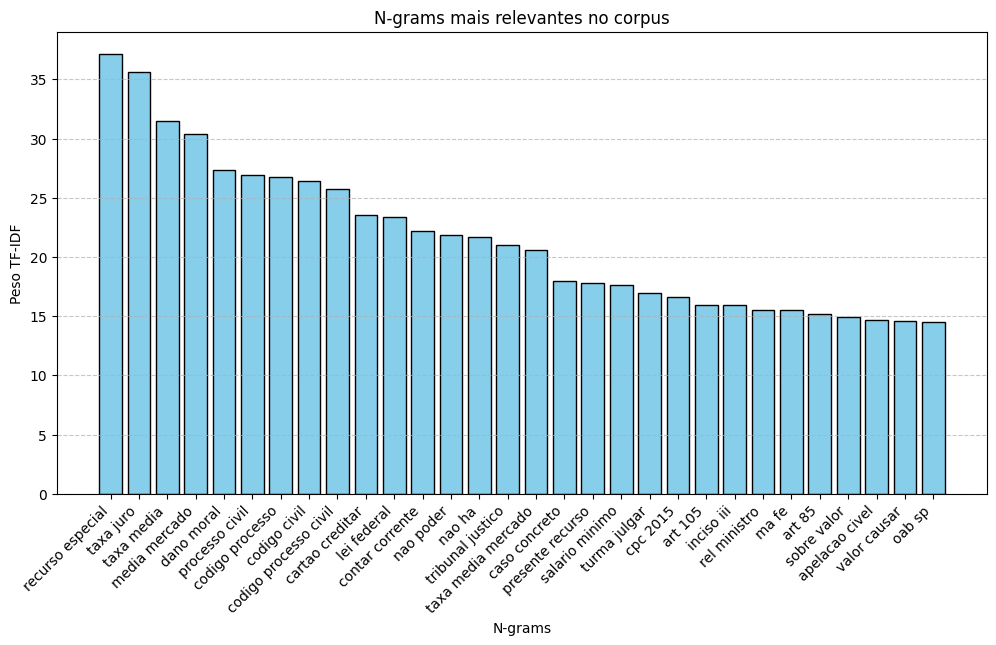

In [96]:
#Plota os N-grams mais relevantes do corpus.
df_ngrams = df_ngrams.sort_values(by="pesoTFIDF", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.bar(df_ngrams['ngram'][:30], df_ngrams['pesoTFIDF'][:30], color='skyblue', edgecolor='black')
plt.xlabel('N-grams')
plt.ylabel('Peso TF-IDF')
plt.title('N-grams mais relevantes no corpus')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('imagens/Ngrams mais relevantes.png', dpi=400, bbox_inches='tight')
plt.show()

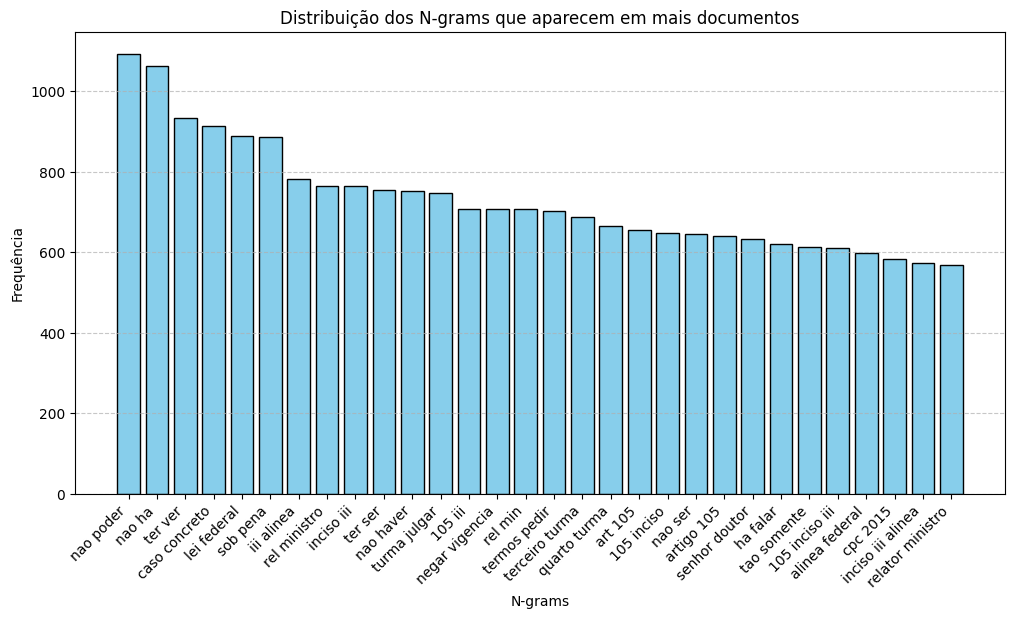

In [97]:
#Plota os N-grams que aparecem em mais documentos.
df_ngrams = df_ngrams.sort_values(by="numero_de_documentos", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.bar(df_ngrams['ngram'][:30], df_ngrams['numero_de_documentos'][:30], color='skyblue', edgecolor='black')
plt.xlabel('N-grams')
plt.ylabel('Frequência')
plt.title('Distribuição dos N-grams que aparecem em mais documentos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('imagens/Ngrams mais documentos.png', dpi=400, bbox_inches='tight')
plt.show()

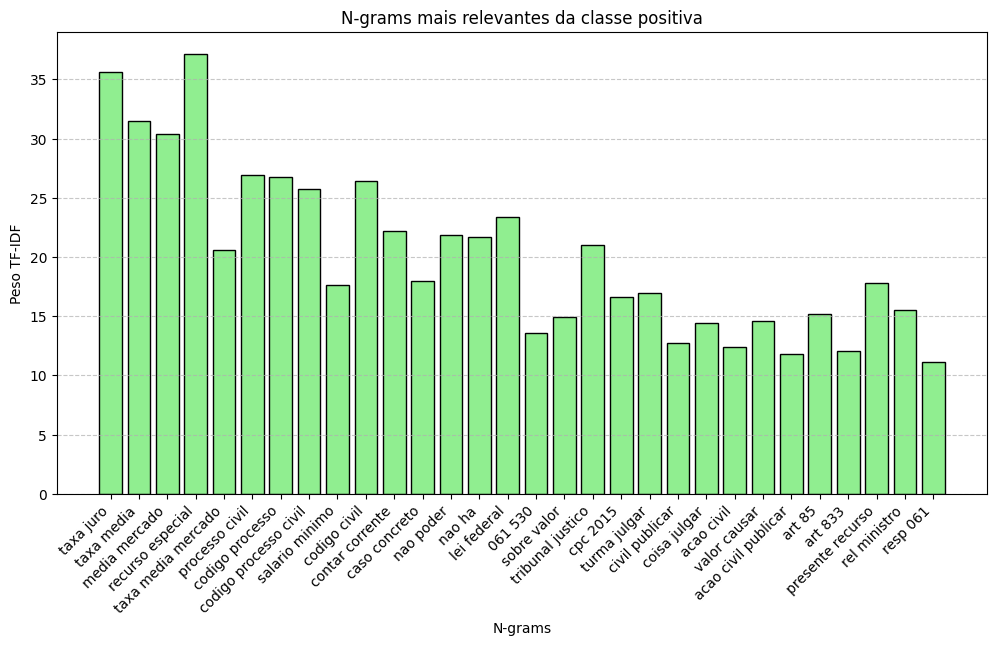

In [98]:
#Plota os N-grams mais relevantes da classe positiva.
df_ngrams = df_ngrams.sort_values(by="peso_y1", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.bar(df_ngrams['ngram'][:30], df_ngrams['pesoTFIDF'][:30], color='lightgreen', edgecolor='black')
plt.xlabel('N-grams')
plt.ylabel('Peso TF-IDF')
plt.title('N-grams mais relevantes da classe positiva')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('imagens/Ngrams mais relevantes y1.png', dpi=400, bbox_inches='tight')
plt.show()

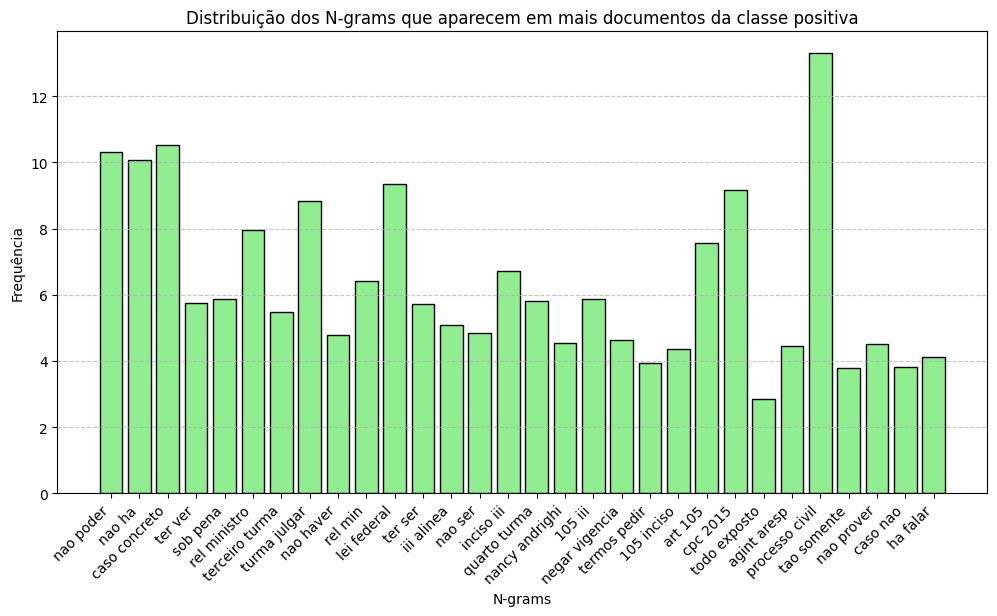

In [99]:
#Plota os N-grams mais frequentes da classe positiva.
df_ngrams = df_ngrams.sort_values(by="numero_de_documentos_y1", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.bar(df_ngrams['ngram'][:30], df_ngrams['peso_y1'][:30], color='lightgreen', edgecolor='black')
plt.xlabel('N-grams')
plt.ylabel('Frequência')
plt.title('Distribuição dos N-grams que aparecem em mais documentos da classe positiva')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('imagens/Ngrams mais documentos y1.png', dpi=400, bbox_inches='tight')
plt.show()

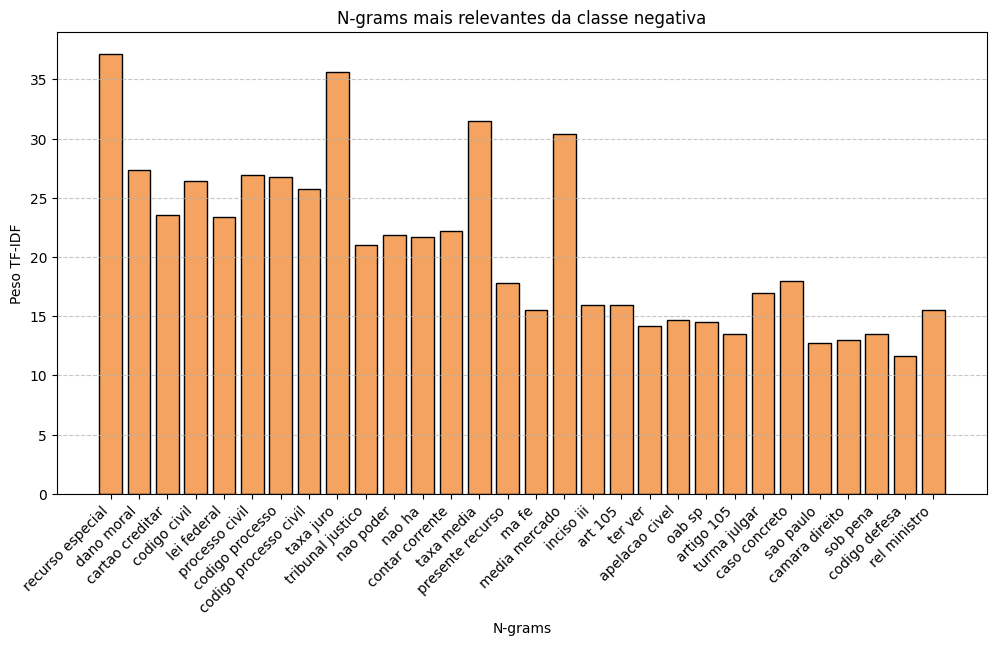

In [100]:
#Plota os N-grams mais relevantes da classe negativa.
df_ngrams = df_ngrams.sort_values(by="peso_y0", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.bar(df_ngrams['ngram'][:30], df_ngrams['pesoTFIDF'][:30], color='sandybrown', edgecolor='black')
plt.xlabel('N-grams')
plt.ylabel('Peso TF-IDF')
plt.title('N-grams mais relevantes da classe negativa')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('imagens/Ngrams mais relevantes y0.png', dpi=400, bbox_inches='tight')
plt.show()

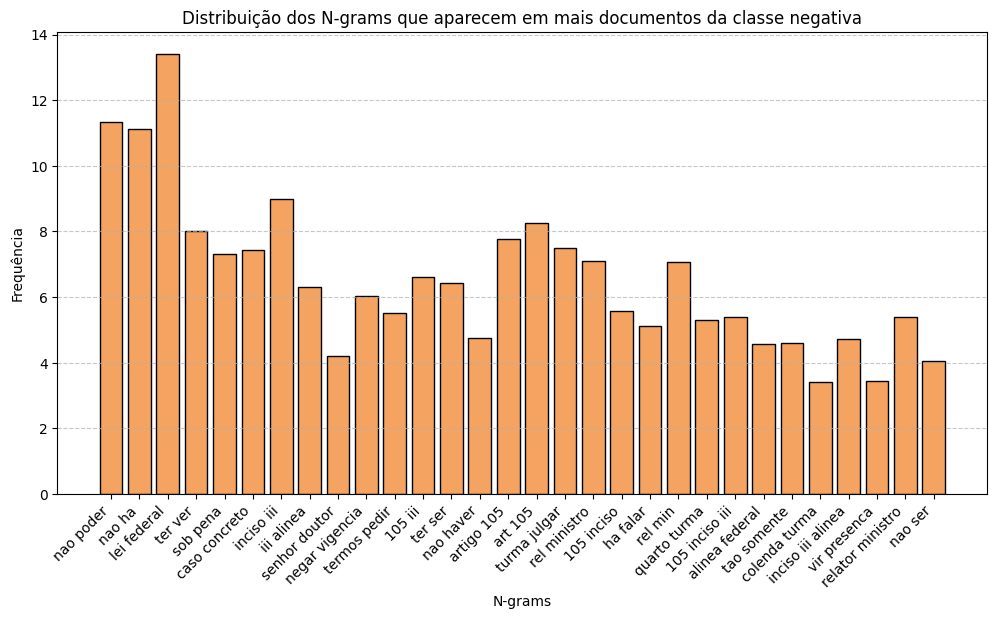

In [101]:
#Plota os N-grams mais frequentes da classe negativa.
df_ngrams = df_ngrams.sort_values(by="numero_de_documentos_y0", ascending=False).reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.bar(df_ngrams['ngram'][:30], df_ngrams['peso_y0'][:30], color='sandybrown', edgecolor='black')
plt.xlabel('N-grams')
plt.ylabel('Frequência')
plt.title('Distribuição dos N-grams que aparecem em mais documentos da classe negativa')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('imagens/Ngrams mais documentos y0.png', dpi=400, bbox_inches='tight')
plt.show()

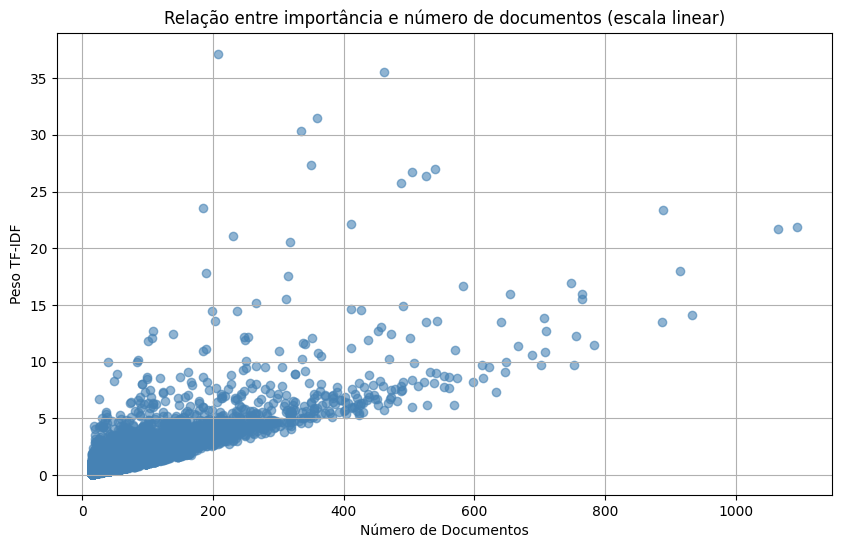

In [102]:
#Plota a relação entre importância e número de documentos.
df_ngrams = df_ngrams.sort_values(by="pesoTFIDF", ascending=False).reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.scatter(df_ngrams['numero_de_documentos'], df_ngrams['pesoTFIDF'], color='steelblue', alpha=0.6)
plt.title('Relação entre importância e número de documentos (escala linear)')
plt.xlabel('Número de Documentos')
plt.ylabel('Peso TF-IDF')
plt.grid(True)
plt.savefig('imagens/Importância documentos linear.png', dpi=400, bbox_inches='tight')
plt.show()

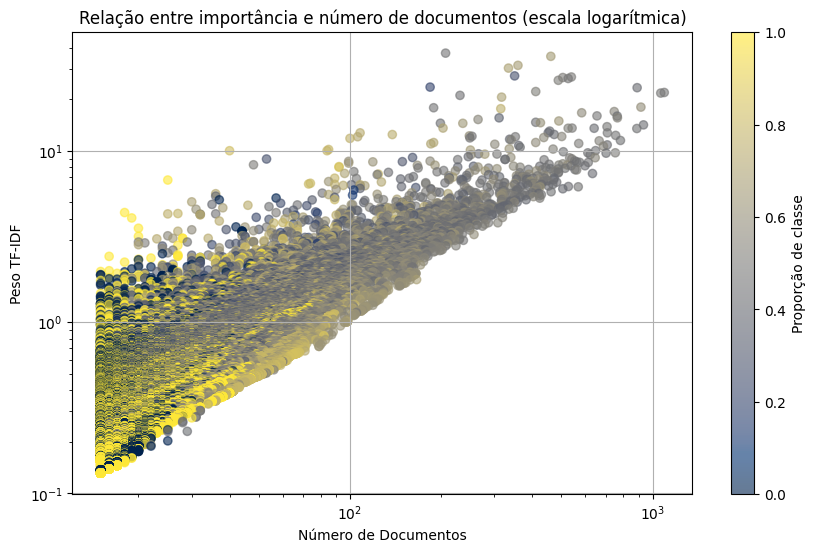

In [103]:
#Plota a relação entre importância e número de documentos, com a proporção do peso para a classe.
df_ngrams = df_ngrams.sort_values(by="pesoTFIDF", ascending=False).reset_index(drop=True)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_ngrams['numero_de_documentos'],
    df_ngrams['pesoTFIDF'],
    c=df_ngrams['proporcao_peso'],  # Valores que definem as cores
    cmap='cividis',  # Escolha de colormap
    alpha=0.6)
cbar = plt.colorbar(scatter)
cbar.set_label('Proporção de classe')
plt.title('Relação entre importância e número de documentos (escala logarítmica)')
plt.xlabel('Número de Documentos')
plt.ylabel('Peso TF-IDF')
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.savefig('imagens/Importância documentos log y01.png', dpi=400, bbox_inches='tight')
plt.show()

Como se observa pela tonalidade da cor, as cores mais fortes à esquerda indicam valores muito discrepantes da proporção de frequência.


In [104]:
#Calcula o Log Likelihood Ratio de cada classe.
n_y0 = df_ngrams['numero_de_documentos_y0'].sum()
n_y1 = df_ngrams['numero_de_documentos_y1'].sum()
n_total = n_y0 + n_y1
def calculate_llr(row):
    k_y0 = row['numero_de_documentos_y0']
    k_y1 = row['numero_de_documentos_y1']
    k = row['numero_de_documentos']
    if k == 0 or n_y0 == 0 or n_y1 == 0:
        return 0
    e_y0 = k * n_y0 / n_total
    e_y1 = k * n_y1 / n_total
    llr_y0 = k_y0 * np.log(k_y0 / e_y0) if k_y0 > 0 else 0
    llr_y1 = k_y1 * np.log(k_y1 / e_y1) if k_y1 > 0 else 0
    return 2 * (llr_y0 + llr_y1)
df_ngrams['LLR'] = df_ngrams.apply(calculate_llr, axis=1)
df_ngrams['LLR'].head()

0    27.606104
1     2.946658
2     2.538856
3     5.406216
4    75.848563
Name: LLR, dtype: float64

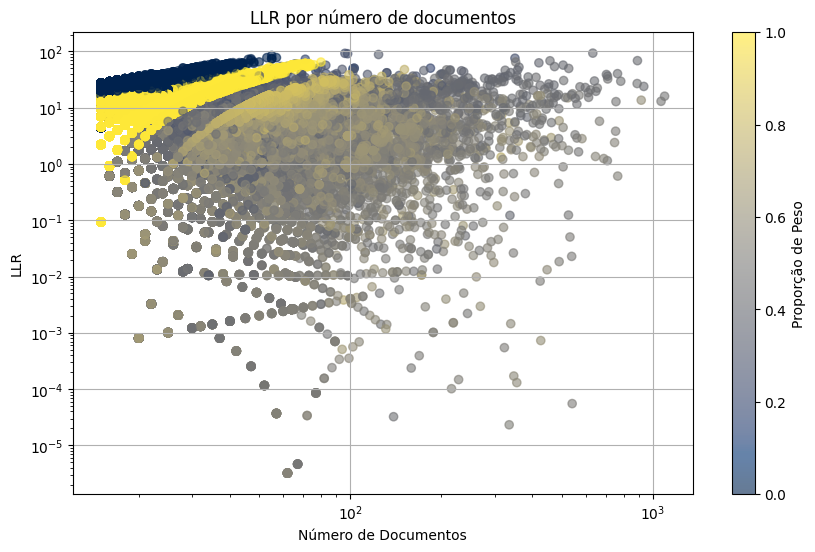

In [105]:
#Plota o LLR ajustado para cada classe pelo número de documentos.
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_ngrams['numero_de_documentos'],
    df_ngrams['LLR'],
    c=df_ngrams['proporcao_peso'],
    cmap='cividis',
    alpha=0.6)
cbar = plt.colorbar(scatter)
cbar.set_label('Proporção de Peso')
plt.title('LLR por número de documentos')
plt.xlabel('Número de Documentos')
plt.ylabel('LLR')
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.savefig('imagens/Scatterplot LLR.png', dpi=400, bbox_inches='tight')
plt.show()

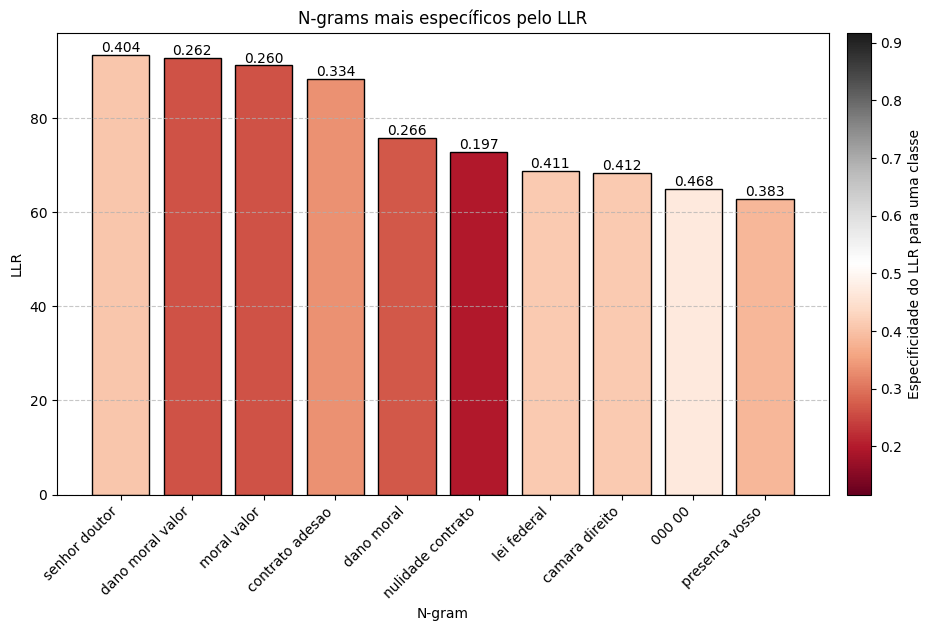

In [106]:
#Plota um gráfico com os N-grams mais específicos, excluídos 0 e 1.
df_filtered = df_ngrams[(df_ngrams['proporcao_peso'] != 0) & (df_ngrams['proporcao_peso'] != 1)]
df_filtered = df_filtered.sort_values(by="LLR", ascending=False).reset_index(drop=True)
cmap = cm.RdGy
norm = Normalize(vmin=df_filtered['proporcao_peso'].min(), 
                 vmax=df_filtered['proporcao_peso'].max())
colors = cmap(norm(df_filtered['proporcao_peso'][:10]))
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(df_filtered['ngram'][:10], 
              df_filtered['LLR'][:10], 
              color=colors, 
              edgecolor='black')
ax.set_xlabel('N-gram')
ax.set_ylabel('LLR')
ax.set_title('N-grams mais específicos pelo LLR')
ax.set_xticks(range(len(df_filtered['ngram'][:10])))
ax.set_xticklabels(df_filtered['ngram'][:10], rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    relevance_value = df_filtered['proporcao_peso'].iloc[i]
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,
            f'{relevance_value:.3f}', ha='center', va='bottom', fontsize=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Especificidade do LLR para uma classe')
plt.savefig('imagens/Ngrams_mais_relevantes_LLR_cmap.png', dpi=400, bbox_inches='tight')
plt.show()

O valor final indica o quão significativamente o termo está associado a uma categoria. Quanto maior o LLR, mais "especial" o termo é para distinguir as classes.

In [107]:
#Guarda a matriz esparsa do Numpy para depois
matriz_tfidf = X.copy()
#Guarda esse dataframe pré-processado para comparação e treino posterior dos modelos.
df_TFIDF = df.copy()

## Parte 7 - Vetorização pelo Doc2Vec

O modelo Doc2Vec é extremamente sensível aos valores aleatórios de inicialização. Para garantir a reprodutibilidade os seguintes passos devem ser observados:
* A variável de ambiente PYTHONHASHSEED deve ser definida para garantir que as sementes dos geradores aleatórios sejam sempre as mesmas. No caso PYTHONHASHSEED=42.
* As seeds random e np.random devem ser 42.
* A seed do modelo deve ser ajustada para 42.
* O número de workers deve ser igual a 1, para eliminar a variação na ordem causada pelo agendamento de threads do sistema operacional.

Fonte: https://radimrehurek.com/gensim/models/doc2vec.html

In [108]:
#Configurar seeds para garantir reprodutibilidade.
random.seed(42)
np.random.seed(42)

In [109]:
df = df_processado.copy()

In [110]:
#Tokeniza o texto já lematizado.
df['tokens'] = df['textoLematizado'].apply(lambda x: x.split())

In [111]:
#Etiqueta os dados de acordo com o documento, conforme exigido pelo Doc2Vec.
tagged_data = [TaggedDocument(words=row['tokens'], tags=[str(i)]) for i, row in df.iterrows()]

In [112]:
#Define os parâmetros para vetorização que serão utilizados pelo Doc2Vec.
modelvec = Doc2Vec(window=10, min_count=10, workers=1, epochs=25, seed=42, shrink_windows=True)

In [113]:
#Constrói o vocabulário que será utilizado para treinar o Doc2Vec.
modelvec.build_vocab(tagged_data)
print(f'O modelo possui {len(modelvec.wv)} vocábulos.\nForam preparados para vetorização {len(modelvec.dv)} documentos.')

O modelo possui 7643 vocábulos.
Foram preparados para vetorização 1500 documentos.


In [114]:
#Treina o modelo Doc2Vec.
modelvec.train(
    tagged_data,
    total_examples=modelvec.corpus_count,
    epochs=modelvec.epochs)

In [115]:
#Define uma função para extrair o vetor referente ao documento.
def get_doc2vec_vector(text, model):
    return model.infer_vector(text)

In [116]:
#Carrega o vetor treinado para cada documento no dataframe.
df['doc2vec'] = df.index.map(lambda i: modelvec.dv[str(i)])

In [117]:
#Exibe os vetores para verificação.
df['doc2vec'][0]

array([ 3.5270653e+00,  1.7980239e+00, -3.2849567e+00, -1.1305273e+00,
       -2.8595917e+00, -1.1343566e+00, -1.9943458e+00, -2.1743026e-01,
        2.4400151e+00, -2.6227725e+00, -2.0432713e+00,  1.6933196e+00,
        1.8689243e+00, -2.0104377e+00, -1.8016951e+00,  2.3065376e+00,
        2.7382009e+00, -6.1129224e-03, -2.1024940e+00, -4.4997158e+00,
        4.9758730e+00, -6.2550879e-01,  1.6260302e-01, -8.8028735e-01,
       -2.1317916e+00,  1.2209281e-01,  1.3712257e+00, -1.2974735e+00,
       -1.8264883e+00,  1.6295755e+00,  2.8809469e+00, -2.1630650e+00,
       -3.9690080e+00, -4.6499887e+00,  1.2641389e+00,  2.7720881e+00,
       -3.2993579e+00, -1.7254437e+00, -1.8804117e+00,  1.5181007e+00,
       -1.0758920e+00,  3.9272571e-01,  3.1923814e+00,  1.2568913e-02,
        9.6335530e-01, -5.3926587e-01, -4.2513790e+00,  1.2621588e+00,
        3.6600938e+00,  1.8669434e-01,  2.4612391e+00, -1.7011539e+00,
        1.8615246e+00,  4.9772429e+00,  1.1936718e+00,  1.1329741e+00,
      

## Parte 8 - Teste de modelos

In [118]:
#Carregar a matriz esparsa TF-IDF.
X1 = load_npz('./misc/matriz_tfidf.npz') #X1 contém os vetores do TF-IDF.

In [119]:
X1.shape

(1500, 70317)

In [120]:
#Carregar vetores Doc2Vec.
X2 = np.array(df['doc2vec'].to_list()) #X2 contém os vetores do Doc2Vec.

In [121]:
X2.shape

(1500, 100)

In [122]:
#Carregar os valores de y (rótulos).
y = df['y'] #y possui os identificadores da classe.

### 8.1 Definir um baseline

In [123]:
#Estabelece os modelos baseline.
baseline_models={
    'Regressão logística':LogisticRegression(random_state=42),
    'K Vizinhos Mais Próximos':KNeighborsClassifier(n_neighbors=5),
    'Máquina de Vetores de Suporte':SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    'Árvore de decisão':DecisionTreeClassifier(random_state=42),
    'Floresta aleatória':RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost':xgb.XGBClassifier(objective='binary:logistic',random_state=42)
}

In [124]:
#Função para gerar os K-folds.
def gera_Kfolds(X,y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = {}
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        folds[i] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    return folds

In [125]:
#Função para calcular as métricas de avaliação de um modelo.
def calcular_metricas(y_true, y_pred, y_prob=None):
    precisao = precision_score(y_true, y_pred)
    revocacao = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acuracia = accuracy_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0
    return {
        'Precisao': round(precisao, 4),
        'Revocacao': round(revocacao, 4),
        'F1-Score': round(f1, 4),
        'AUC-ROC': round(auc_roc, 4),
        'Especificidade': round(especificidade, 4),
        'Acuracia': round(acuracia, 4)
    }

In [126]:
def gera_baseline_conjunto(dicionario, modelos, X, y):
    folds = gera_Kfolds(X, y)
    for nome_modelo in modelos.keys():
        if nome_modelo not in dicionario:
            dicionario[nome_modelo] = {}
        for fold in folds:
            modelo = modelos[nome_modelo]
            modelo.fit(folds[fold]['X_train'], folds[fold]['y_train'])
            y_pred = modelo.predict(folds[fold]['X_test'])
            y_pred_proba = modelo.predict_proba(folds[fold]['X_test'])[:, 1]
            result_fold = calcular_metricas(folds[fold]['y_test'], y_pred, y_pred_proba)
            dicionario[nome_modelo][fold] = result_fold

In [127]:
#Gera os resultados de baseline dos modelos para a vetorização TF-IDF.
baseline_tdidf = {}
gera_baseline_conjunto(baseline_tdidf,baseline_models,X1,y)

In [128]:
#Gera os resultados de baseline dos modelos para a vetorização Doc2Vec.
baseline_doc2v = {}
gera_baseline_conjunto(baseline_doc2v,baseline_models,X2,y)

In [129]:
#Cria um dataframe multiindex para armazenar os dados de baseline.
def cria_df_mi(dicionario):
    # Lista para armazenar os dados do DataFrame
    dados = []
    for modelo, folds_data in dicionario.items():
        for fold, metricas in folds_data.items():
            dados.append([modelo, fold, metricas['Precisao'], metricas['Revocacao'],
                          metricas.get('F1-Score', None), metricas.get('AUC-ROC', None),
                          metricas.get('Especificidade', None), metricas.get('Acuracia', None)])
    index = pd.MultiIndex.from_tuples([(modelo, fold) for modelo, folds_data in dicionario.items()
                                       for fold in folds_data], names=['Modelo', 'Fold'])
    df = pd.DataFrame(dados, columns=['Modelo', 'Fold', 'Precisao', 'Revocacao', 'F1-Score', 'AUC-ROC', 'Especificidade', 'Acuracia'])
    df.set_index(['Modelo', 'Fold'], inplace=True)
    df.rename(columns={
    'Precisao': 'Precisão',
    'Revocacao': 'Revocação',
    'F1-Score': 'F1-Score',
    'AUC-ROC': 'AUC-ROC',
    'Especificidade': 'Especificidade',
    'Acuracia': 'Acurácia'},
              inplace=True)
    return df

In [130]:
df_tfidf = cria_df_mi(baseline_tdidf)
df_doc2v = cria_df_mi(baseline_doc2v)

In [131]:
df_tfidf

Precisão  Revocação  F1-Score  AUC-ROC  \
Modelo                        Fold                                           
Regressão logística           0       0.7763     0.7662    0.7712   0.8459   
                              1       0.7536     0.7172    0.7350   0.8509   
                              2       0.8108     0.8276    0.8191   0.8811   
                              3       0.7143     0.6897    0.7018   0.8113   
                              4       0.8309     0.7019    0.7609   0.8564   
K Vizinhos Mais Próximos      0       0.7066     0.7662    0.7352   0.7739   
                              1       0.6867     0.7862    0.7331   0.7812   
                              2       0.7305     0.8414    0.7821   0.8390   
                              3       0.7012     0.7931    0.7443   0.7856   
                              4       0.7545     0.7826    0.7683   0.7933   
Máquina de Vetores de Suporte 0       0.7857     0.7143    0.7483   0.8385   
                              1       0.7794     0.7310    0.7544   0.8527   
                              2       0.8151     0.8207    0.8179   0.8869   
                              3       0.7481     0.6966    0.7214   0.8181   
                              4       0.8473     0.6894    0.7603   0.8610   
Árvore de decisão             0       0.6761     0.6234    0.6486   0.6542   
                              1       0.6889     0.6414    0.6643   0.6852   
                              2       0.6376     0.6552    0.6463   0.6534   
                              3       0.6481     0.7241    0.6840   0.6782   
                              4       0.7397     0.6708    0.7036   0.6987   
Floresta aleatória            0       0.7597     0.7597    0.7597   0.8121   
                              1       0.7417     0.7724    0.7568   0.8302   
                              2       0.7718     0.7931    0.7823   0.8673   
                              3       0.7092     0.6897    0.6993   0.7963   
                              4       0.8593     0.7205    0.7838   0.8699   
XGBoost                       0       0.7368     0.7273    0.7320   0.8026   
                              1       0.7347     0.7448    0.7397   0.8221   
                              2       0.7770     0.7931    0.7850   0.8651   
                              3       0.7248     0.7448    0.7347   0.8218   
                              4       0.7829     0.7391    0.7604   0.8185   

                                    Especificidade  Acurácia  
Modelo                        Fold                            
Regressão logística           0             0.7671    0.7667  
                              1             0.7806    0.7500  
                              2             0.8194    0.8233  
                              3             0.7419    0.7167  
                              4             0.8345    0.7633  
K Vizinhos Mais Próximos      0             0.6644    0.7167  
                              1             0.6645    0.7233  
                              2             0.7097    0.7733  
                              3             0.6839    0.7367  
                              4             0.7050    0.7467  
Máquina de Vetores de Suporte 0             0.7945    0.7533  
                              1             0.8065    0.7700  
                              2             0.8258    0.8233  
                              3             0.7806    0.7400  
                              4             0.8561    0.7667  
Árvore de decisão             0             0.6849    0.6533  
                              1             0.7290    0.6867  
                              2             0.6516    0.6533  
                              3             0.6323    0.6767  
                              4             0.7266    0.6967  
Floresta aleatória            0             0.7466    0.7533  
                              1             0.7484    0.7600  
                           

In [132]:
df_doc2v

Precisão  Revocação  F1-Score  AUC-ROC  \
Modelo                        Fold                                           
Regressão logística           0       0.5725     0.5130    0.5411   0.5545   
                              1       0.6181     0.6138    0.6159   0.6597   
                              2       0.5161     0.5517    0.5333   0.6172   
                              3       0.5769     0.6207    0.5980   0.6292   
                              4       0.6000     0.5776    0.5886   0.5896   
K Vizinhos Mais Próximos      0       0.7266     0.6039    0.6596   0.7337   
                              1       0.7090     0.6552    0.6810   0.7749   
                              2       0.7946     0.6138    0.6926   0.7842   
                              3       0.7724     0.6552    0.7090   0.7929   
                              4       0.7638     0.6025    0.6736   0.7467   
Máquina de Vetores de Suporte 0       0.6761     0.6234    0.6486   0.7273   
                              1       0.7536     0.7172    0.7350   0.8278   
                              2       0.7429     0.7172    0.7298   0.8019   
                              3       0.7361     0.7310    0.7336   0.7945   
                              4       0.7500     0.7081    0.7284   0.7753   
Árvore de decisão             0       0.5931     0.5584    0.5753   0.5772   
                              1       0.5724     0.5724    0.5724   0.5862   
                              2       0.6013     0.6345    0.6174   0.6205   
                              3       0.5586     0.5586    0.5586   0.5729   
                              4       0.6770     0.6770    0.6770   0.6515   
Floresta aleatória            0       0.6741     0.5909    0.6298   0.7370   
                              1       0.6861     0.6483    0.6667   0.7645   
                              2       0.6667     0.6621    0.6644   0.7625   
                              3       0.6398     0.7103    0.6732   0.7278   
                              4       0.7027     0.6460    0.6731   0.7570   
XGBoost                       0       0.7133     0.6623    0.6869   0.7287   
                              1       0.6835     0.6552    0.6690   0.7541   
                              2       0.7068     0.6483    0.6763   0.7610   
                              3       0.6382     0.6690    0.6532   0.7347   
                              4       0.6839     0.6584    0.6709   0.7332   

                                    Especificidade  Acurácia  
Modelo                        Fold                            
Regressão logística           0             0.5959    0.5533  
                              1             0.6452    0.6300  
                              2             0.5161    0.5333  
                              3             0.5742    0.5967  
                              4             0.5540    0.5667  
K Vizinhos Mais Próximos      0             0.7603    0.6800  
                              1             0.7484    0.7033  
                              2             0.8516    0.7367  
                              3             0.8194    0.7400  
                              4             0.7842    0.6867  
Máquina de Vetores de Suporte 0             0.6849    0.6533  
                              1             0.7806    0.7500  
                              2             0.7677    0.7433  
                              3             0.7548    0.7433  
                              4             0.7266    0.7167  
Árvore de decisão             0             0.5959    0.5767  
                              1             0.6000    0.5867  
                              2             0.6065    0.6200  
                              3             0.5871    0.5733  
                              4             0.6259    0.6533  
Floresta aleatória            0             0.6986    0.6433  
                              1             0.7226    0.6867  
                           

In [133]:
#Define valores para o ColorMap.
c_min = min(df_tfidf.min().min(),df_doc2v.min().min())
c_max = max(df_tfidf.max().max(),df_doc2v.max().max())

In [134]:
#Gera os dataframes médios e máximos.
df_tfidf_media = df_tfidf.groupby('Modelo').mean()
df_tfidf_max = df_tfidf.loc[df_tfidf.groupby('Modelo')['Revocação'].idxmax()]
df_tfidf_max = df_tfidf_max.droplevel(level='Fold')
df_doc2v_media = df_doc2v.groupby('Modelo').mean()
df_doc2v_max = df_doc2v.loc[df_tfidf.groupby('Modelo')['Revocação'].idxmax()]
df_doc2v_max = df_doc2v_max.droplevel(level='Fold')
for df in df_tfidf_media,df_tfidf_max,df_doc2v_media,df_doc2v_max:
    df.sort_values(by='Revocação', ascending=False, inplace=True)

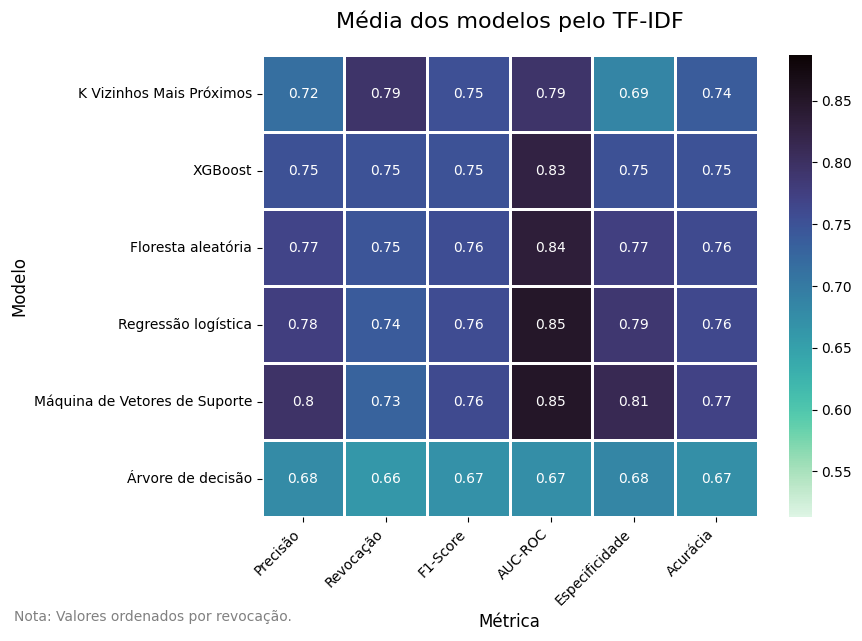

In [135]:
#Heatmap da média do TF-IDF.
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    df_tfidf_media, 
    annot=True, 
    cmap='mako_r', 
    linewidths=1, 
    vmin=c_min,
    vmax=c_max)
plt.title("Média dos modelos pelo TF-IDF", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Modelo", fontsize=12)
plt.text(x=-0.5,y=-0.2, s="Nota: Valores ordenados por revocação.", fontsize=10, color='gray', ha='left', va='top', transform=plt.gca().transAxes)
plt.savefig('imagens/media_tfidf.png', dpi=400, bbox_inches='tight')
plt.show()

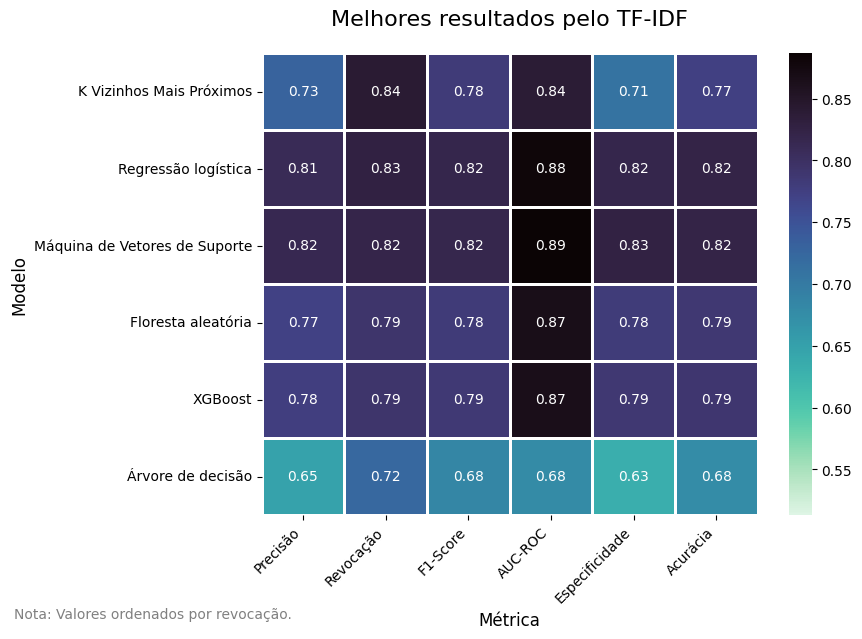

In [136]:
#Heatmap da dos melhores resultados do TF-IDF.
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    df_tfidf_max, 
    annot=True, 
    cmap='mako_r', 
    linewidths=1, 
    vmin=c_min,
    vmax=c_max)
plt.title("Melhores resultados pelo TF-IDF", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Modelo", fontsize=12)
plt.text(x=-0.5,y=-0.2, s="Nota: Valores ordenados por revocação.", fontsize=10, color='gray', ha='left', va='top', transform=plt.gca().transAxes)
plt.savefig('imagens/max_tfidf.png', dpi=400, bbox_inches='tight')
plt.show()

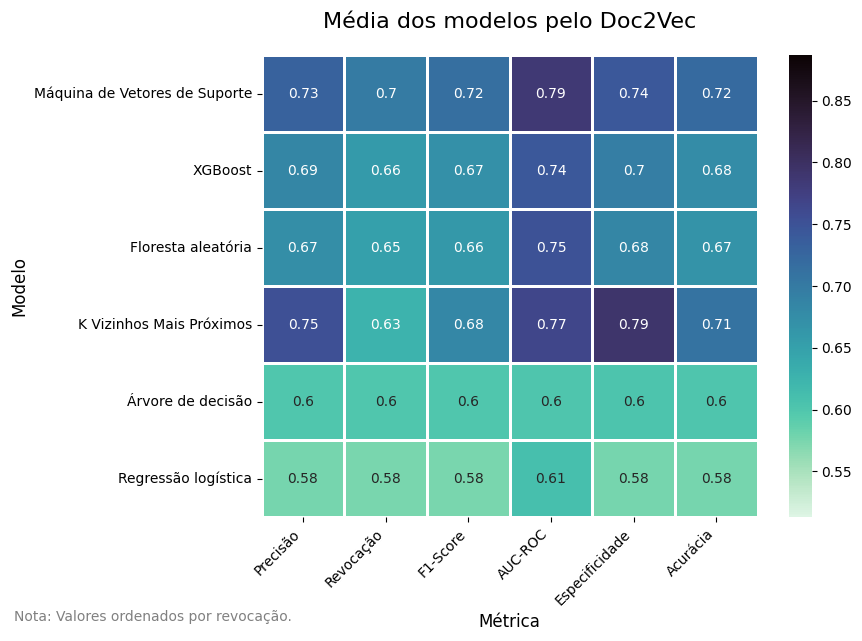

In [137]:
#Heatmap da média do Doc2Vec.
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    df_doc2v_media, 
    annot=True, 
    cmap='mako_r', 
    linewidths=1, 
    vmin=c_min,
    vmax=c_max)
plt.title("Média dos modelos pelo Doc2Vec", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Modelo", fontsize=12)
plt.text(x=-0.5,y=-0.2, s="Nota: Valores ordenados por revocação.", fontsize=10, color='gray', ha='left', va='top', transform=plt.gca().transAxes)
plt.savefig('imagens/media_doc2vec.png', dpi=400, bbox_inches='tight')
plt.show()

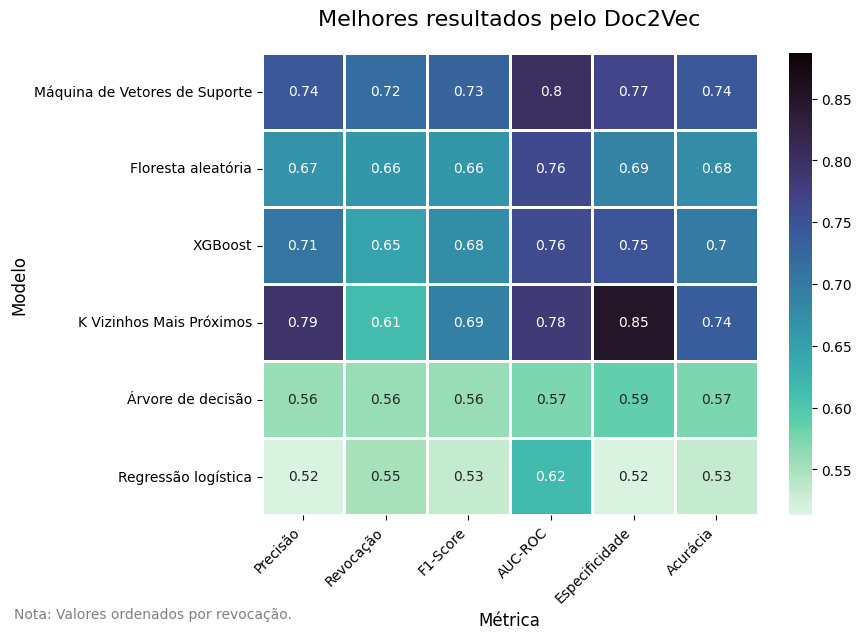

In [138]:
#Heatmap da dos melhores resultados do Doc2Vec.
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    df_doc2v_max, 
    annot=True, 
    cmap='mako_r', 
    linewidths=1, 
    vmin=c_min,
    vmax=c_max)
plt.title("Melhores resultados pelo Doc2Vec", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Modelo", fontsize=12)
plt.text(x=-0.5,y=-0.2, s="Nota: Valores ordenados por revocação.", fontsize=10, color='gray', ha='left', va='top', transform=plt.gca().transAxes)
plt.savefig('imagens/max_doc2vec.png', dpi=400, bbox_inches='tight')
plt.show()

A principal métrica utilizada nesse trabalho foi o *recall* revocação. Logo, o modelo que obteve o melhor KNN foi o escolhido para otimização.

In [139]:
#Divisão dos dados em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

In [140]:
#Elimina alguns avisos do opt.fit informando que algum modelo já foi avaliado.
filterwarnings("ignore", message=".*The objective has been evaluated at point.*")
filterwarnings("ignore", category=RuntimeWarning)

In [141]:
#Configurando a busca Bayesiana.
knn = KNeighborsClassifier(n_jobs=-1,algorithm='brute')
param_space = {
    'n_neighbors': Integer(2, 20),
    'weights': Categorical(['uniform', 'distance']),
    'p': Categorical([1, 2]),
    'metric': Categorical(['minkowski', 'euclidean', 'manhattan'])}
opt = BayesSearchCV(
    estimator=knn, 
    search_spaces=param_space, 
    n_iter=50, 
    cv=5, 
    n_jobs=-1, 
    scoring=make_scorer(recall_score, pos_label=1),
    random_state=42)

In [142]:
# Treinando o modelo com a busca Bayesiana.
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=KNeighborsClassifier(algorithm='brute', n_jobs=-1),
              n_jobs=-1, random_state=42,
              scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
              search_spaces={'metric': Categorical(categories=('minkowski', 'euclidean', 'manhattan'), prior=None),
                             'n_neighbors': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'p': Categorical(categories=(1, 2), prior=None),
                             'weights': Categorical(categories=('uniform', 'distance'), prior=None)})

In [143]:
# Exibindo os melhores parâmetros encontrados.
print("Melhores parâmetros encontrados:", opt.best_params_)

Melhores parâmetros encontrados: OrderedDict({'metric': 'euclidean', 'n_neighbors': 11, 'p': 2, 'weights': 'distance'})


In [144]:
# Exibindo o melhor desempenho (recall).
print("Melhor performance (recall):", opt.best_score_)

Melhor performance (recall): 0.7986134453781512


In [145]:
results_knn = pd.DataFrame(opt.cv_results_).sort_values(by='mean_test_score', ascending=False, inplace=True)
results_knn

In [146]:
opt.best_params_

OrderedDict([('metric', 'euclidean'),
             ('n_neighbors', 11),
             ('p', 2),
             ('weights', 'distance')])

In [147]:
#Gerando dobras para o último gráfico.
folds = gera_Kfolds(X1,y)

In [148]:
#Treina um modelo utilizando os melhores parâmetros do KNN.
melhor_knn = { }
for fold in folds:
    modelo = KNeighborsClassifier(
        n_jobs=-1,
        algorithm='brute',
        n_neighbors=opt.best_params_['n_neighbors'],
        weights=opt.best_params_['weights'],
        p=opt.best_params_['p'],
        metric=opt.best_params_['metric'])
    modelo.fit(folds[fold]['X_train'], folds[fold]['y_train'])
    y_pred = modelo.predict(folds[fold]['X_test'])
    y_pred_proba = modelo.predict_proba(folds[fold]['X_test'])[:, 1]
    result_fold = calcular_metricas(folds[fold]['y_test'], y_pred, y_pred_proba)
    melhor_knn[fold] = result_fold

In [149]:
#Obtém as métricas do modelo KNN com o melhor parâmetro.
df_KNN = pd.DataFrame(melhor_knn)
df_KNN = df_KNN.transpose()
df_KNN.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5']
df_KNN.loc['Média'] = df_KNN.mean(numeric_only=True)
df_KNN.sort_values(by='Revocacao', ascending=False, inplace=True)
df_KNN.rename(columns={
    'Precisao': 'Precisão',
    'Revocacao': 'Revocação',
    'F1-Score': 'F1-Score',
    'AUC-ROC': 'AUC-ROC',
    'Especificidade': 'Especificidade',
    'Acuracia': 'Acurácia'},inplace=True)
df_KNN

,Precisão,Revocação,F1-Score,AUC-ROC,Especificidade,Acurácia
Fold 3,0.75480,0.8069,0.78000,0.86550,0.75480,0.78000
Fold 4,0.69880,0.8000,0.74600,0.79250,0.67740,0.73670
Fold 5,0.79010,0.7950,0.79260,0.84140,0.75540,0.77670
Média,0.73112,0.7856,0.75706,0.81486,0.71104,0.74802
Fold 2,0.71070,0.7793,0.74340,0.79850,0.70320,0.74000
Fold 1,0.70120,0.7468,0.72330,0.77640,0.66440,0.70670


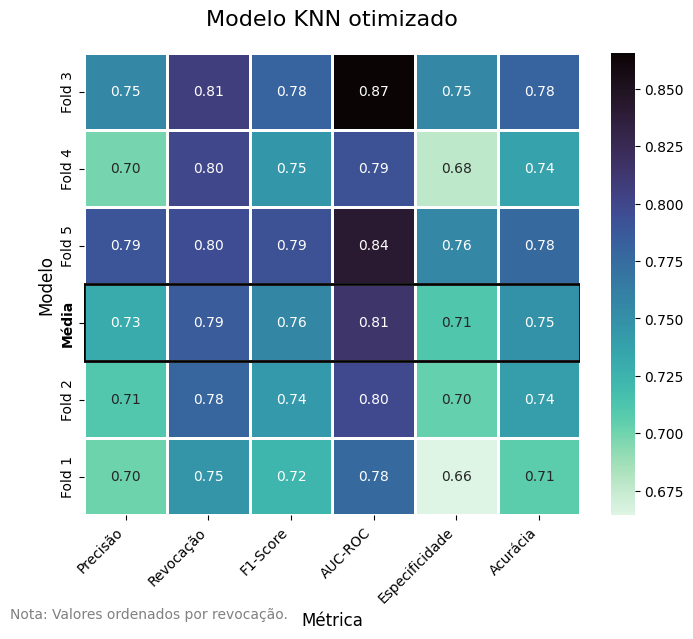

In [150]:
# Plotando o heatmap final.
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    df_KNN,
    annot=True,
    fmt=".2f",
    cmap="mako_r",
    ax=ax,
    cbar=True,
    linewidths=1,
    xticklabels=True,
    yticklabels=True)
plt.title("Modelo KNN otimizado", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Inclinação e alinhamento
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Modelo", fontsize=12)
plt.text(x=-0.15,y=-0.2, s="Nota: Valores ordenados por revocação.", fontsize=10, color='gray', ha='left', va='top', transform=plt.gca().transAxes)
linha_destacada = 3
ax.add_patch(plt.Rectangle((0, linha_destacada), df_KNN.shape[1], 1, edgecolor='black', fill=False, lw=2))
yticks = ax.get_yticklabels()
yticks[linha_destacada].set_fontweight("bold")
ax.set_yticklabels(yticks)
plt.savefig('imagens/KNN_otimizado.png', dpi=400, bbox_inches='tight')
plt.show()